# Neural network Keras version for ML CUP

## Imports

In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K

## Utils

In [61]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy from a model's history, 
    adding the parameters as a title.

    Parameters:
    - history: History object returned by model.fit().
    - params: Dictionary containing the model parameters.
    """

    # Estrai dati dalla history
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    train_mee = history.history.get('mean_euclidean_error', [])
    val_mee = history.history.get('val_mean_euclidean_error', [])
    
    epochs = range(1, len(train_loss) + 1)  # Numero di epoche

    # Grafico della Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-o', label='Training MSE')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-o', label='Validation MSE')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Grafico dell'Accuracy
    plt.subplot(1, 2, 2)
    if train_mee:
        plt.plot(epochs, train_mee, 'b-o', label='Training MEE')
    if val_mee:
        plt.plot(epochs, val_mee, 'r-o', label='Validation MEE')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    #plt.tight_layout()
    plt.show()

In [62]:
def generate_hyperparameter_combinations(param_ranges):
    """
    Genera tutte le combinazioni di iperparametri basate su range e step specificati.

    :param param_ranges: Dizionario con i nomi degli iperparametri come chiavi.
                         Ogni valore è una tupla (start, stop, step).
    :return: Lista di dizionari con tutte le combinazioni possibili.
    """
    param_values = {
        key: np.arange(start, stop + step, step)
        for key, (start, stop, step) in param_ranges.items()
    }
    
    param_combinations = list(itertools.product(*param_values.values()))
    return [
        dict(zip(param_values.keys(), combination))
        for combination in param_combinations
    ]

In [63]:
def mean_euclidean_error(y_true, y_pred):
    """
    Mean Euclidean Error (MEE) calculation.

    Parameters:
        y_true: True target values.
        y_pred: Predicted target values.

    Returns:
        Mean Euclidean Error.
    """
    return K.mean(K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1)))

## Data load

In [64]:
# Load dataset
train_path = '../Datasets/CUP/ML-CUP24-TR.csv'
test_path = '../Datasets/CUP/ML-CUP24-TS.csv'
data_train = pd.read_csv(train_path, skiprows=7)
data_test = pd.read_csv(test_path, skiprows=7)


# Drop the ID column and split inputs/outputs
X_train = data_train.iloc[:, 1:-3].values  # INPUTS (12 columns)
y_train = data_train.iloc[:, -3:].values  # TARGET_x, TARGET_y, TARGET_z

# Drop the ID column and split inputs/outputs
X_test = data_test.iloc[:, 1:].values

# Standardize inputs (mean 0, std 1)
input_scaler = StandardScaler()
X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

# Normalize outputs (Min-Max scaling to [0, 1])
output_scaler = MinMaxScaler()
y_train_scaled = output_scaler.fit_transform(y_train)


## Model creation

In [65]:
def create_nn(input_dim, output_dim = 3, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, learning_rate=0.01,
              hidden_size=6, hidden_layers=1, regularization=0.01, momentum=0.9, alpha=0.01):
    """
    Create a binary classification neural network with Leaky ReLU and configurable parameters.
    
    Parameters:
    - input_dim (int): Number of input features.
    - learning_rate (float): Learning rate for the optimizer.
    - hidden_size (int): Number of nodes in each hidden layer.
    - hidden_layers (int): Number of hidden layers.
    - regularization (float): L2 regularization factor.
    - momentum (float): Momentum for the optimizer.
    - alpha (float): Negative slope coefficient for Leaky ReLU.
    
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()
    

    # Input layer (using Input layer explicitly)
    model.add(Input(shape=(input_dim,)))  # Input layer defined explicitly

    if reg_flag & (activ_type == 'licky_relu'):
        # Hidden layers with Leaky ReLU 
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size,
                            kernel_regularizer=l2(regularization)))
            model.add(LeakyReLU(negative_slope=alpha))  # Updated to use negative_slope parameter

    elif (not reg_flag) & (activ_type == 'licky_relu'):
         # Hidden layers with Leaky ReLU 
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size))
            model.add(LeakyReLU(negative_slope=alpha))  # Updated to use negative_slope parameter

    elif reg_flag:
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type,
                         kernel_regularizer=regularizers.l2(regularization)
                        ))  # ReLU activation directly in Dense layer
    else:
        for _ in range(hidden_layers):
            model.add(Dense(hidden_size, activation=activ_type))  # ReLU activation directly in Dense layer


    
    # Output layer (binary classification)
    model.add(Dense(output_dim, activation='linear'))

    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    if optim_type == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error', metrics=['mae', mean_euclidean_error])
    
    return model

## K-fold cross validation

In [66]:
def k_fold_cross_validation(data, labels,  activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, in_size = 12, out_size = 3, params=None):
    # Configurazione della k-fold cross-validation
    kfold = KFold(n_splits=4, shuffle=True, random_state=42)


    # EarlyStopping callback con pazienza
    early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation MEE
                                    patience=10,                         # Stop if no improvement for 10 epochs
                                    restore_best_weights=True)           # Restore the weights of the best epoch

    # 4. Ciclo di cross-validation
    fold_no = 1
    mee_per_fold = []
    for train_index, val_index in kfold.split(data):
        
        # Suddivisione del dataset
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]

        # Creazione della rete neurale
        model = create_nn(input_dim=in_size,
                            output_dim=out_size,
                            activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'], 
                            alpha=params['alpha'])


        # Addestramento con EarlyStopping
        history = model.fit(X_train, y_train,
                            epochs=params['epochs'], 
                            batch_size=params['batch_size'], 
                            validation_data=(X_val, y_val),
                            verbose=0, 
                            callbacks=[early_stopping])

        # Prendi il miglior score (l'accuratezza di validazione massima)
        score = min(history.history['val_mean_euclidean_error'])
        mee_per_fold.append(score)    
        fold_no += 1

    avg_score = np.mean(mee_per_fold)


    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


    # Creazione della rete neurale
    model = create_nn(input_dim=in_size,
                            output_dim=out_size,
                            activ_type = activ_type,
                            optim_type = optim_type,
                            reg_flag = reg_flag,
                            learning_rate=params['learning_rate'], 
                            hidden_size=params['hidden_size'], 
                            hidden_layers=params['hidden_layers'], 
                            regularization=params['regularization'], 
                            momentum=params['momentum'], 
                            alpha=params['alpha'])

    # Addestramento finale con EarlyStopping
    history = model.fit(X_train, y_train, 
                        epochs=params['epochs'], 
                        batch_size=params['batch_size'], 
                        validation_data=(X_val, y_val),
                        verbose=0, 
                        callbacks=[early_stopping])

    return avg_score, history, model

## Greedy search

In [67]:
def greed_search(data, labels, activ_type = 'tanh', optim_type = 'SGD', reg_flag = False, input_size = 6, output_size = 3, param_grid = None):
    best_scores = []  # Usa una lista normale per memorizzare i punteggi
    best_params_list = []  # Lista per le configurazioni
    best_models = []  # Lista per i modelli
    best_histories = []  # Lista per la cronologia

    for params in param_grid:
        print("--------------------------------------------------")
        print(f"Testing params: {params}")
        score, history, model = k_fold_cross_validation(data, labels, activ_type, optim_type, reg_flag, input_size, 
                                                        out_size=output_size, params=params)
        print(f"Score : {score}")

        # Aggiungi i risultati alla lista
        best_scores.append(score)
        best_params_list.append(params)
        best_models.append(model)
        best_histories.append(history)

        # Ordina i punteggi in ordine crescente
        sorted_indices = np.argsort(best_scores)  
        best_scores = [best_scores[i] for i in sorted_indices][:10]  # Mantieni i top 10 in ordine crescente
        best_params_list = [best_params_list[i] for i in sorted_indices][:10]
        best_models = [best_models[i] for i in sorted_indices][:10]
        best_histories = [best_histories[i] for i in sorted_indices][:10]

    print("--------------------END GREED SEARCH------------------------------")

    # Ora hai i 10 migliori risultati
    # print("Top 10 best scores:")
    #print(best_scores)
    #print("Top 10 best params:")
    #print(best_params_list)

    return best_scores, best_params_list, best_models, best_histories

## Model selection

In [68]:
best_scores = []  # Usa una lista di tre elementi per memorizzare i punteggi
best_params_list = []  # Lista di tre elementi per le configurazioni
best_models = []  # Lista di tre elementi per i modelli
best_histories = []  # Lista di tre elementi per la storia di allenamento

# Seleziona 100 elementi a caso senza rimpiazzamento
#np.random.choice(param_grid, size=100, replace=False)

--------------------------------------------------
Testing params: {'learning_rate': 0.03, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score : 0.07461204566061497
--------------------------------------------------
Testing params: {'learning_rate': 0.04, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score : 0.07707668002694845
--------------------END GREED SEARCH------------------------------
--------------------------------------------------Plots--------------------------------------------------
{'learning_rate': 0.03, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.07461204566061497


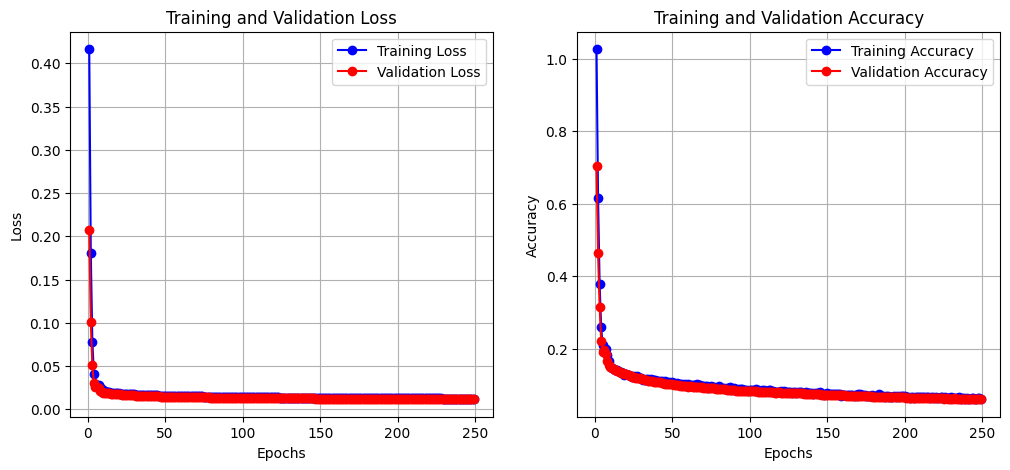

{'learning_rate': 0.04, 'epochs': 700, 'batch_size': 128, 'hidden_size': 80, 'hidden_layers': 2, 'momentum': 0.8, 'regularization': 0.0001, 'alpha': 0.01, 'patience': 30}
Score: 0.07707668002694845


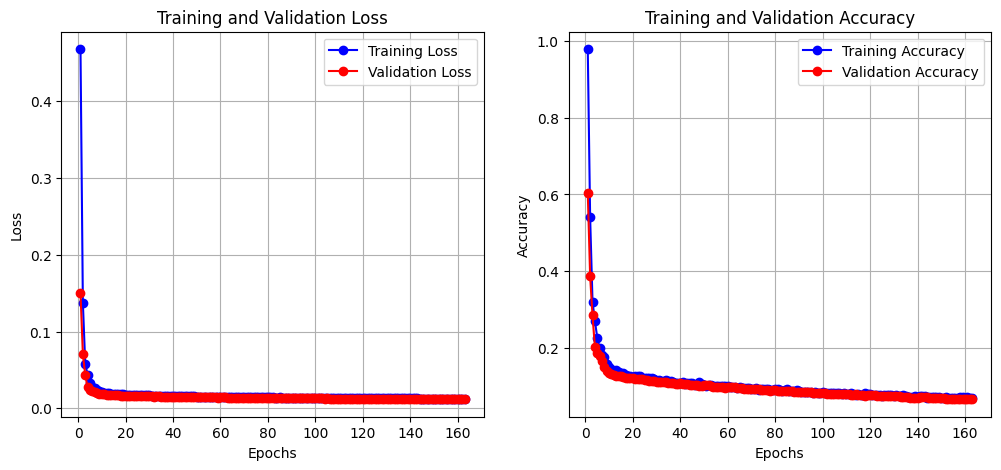

In [70]:
input_size = X_train_scaled.shape[1]
output_size = y_train_scaled.shape[1]

# Definizione dei range degli iperparametri
param_ranges = {
    "learning_rate": (0.03, 0.03, 0.01),  # Da 0.01 a 0.5 con step di 0.05
    "epochs": (700, 700, 1),                   # Da 0 a 10 con step di 1
    "batch_size": (128, 128, 1),             # Da 8 a 32 con step di 8
    "hidden_size": (80, 80, 1),           # Da 32 a 128 con step di 32
    "hidden_layers": (2, 2, 1),             # Da 1 a 3 con step di 1
    "momentum": (0.8, 0.8, 0.1),          # Da 0.9 a 0.99 con step di 0.01
    "regularization": (0.0001, 0.0001, 0.0005),             # Da 0.0 a 0.1 con step di 0.05
    "alpha": (0.01, 0.01, 0.01),             # Da 0.01 a 0.1 con step di 0.05
    "patience": (30, 30, 1)            # Da 5 a 15 con step di 5
}

param_grid = []
param_grid = generate_hyperparameter_combinations(param_ranges)

best_scores, best_params_list, best_models, best_histories = greed_search(X_train_scaled, y_train_scaled, 
                                                                                      'tanh', 'SGD', True, 
                                                                                      input_size, output_size, param_grid)

print("--------------------------------------------------Plots--------------------------------------------------")
for i, (history, params, score) in enumerate(zip(best_histories, best_params_list, best_scores)):
    print(f"{params}")
    print(f"Score: {score}")
    plot_training_history(history)